# Pre-processing

## Quality Control

### Remove Empty Droplet using drokick 

In [ ]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
#@title Dropkick run
# To skip running this code cell run the following command

%%script echo skipping



# simple preprocessing of anndata object to get metrics for plot
adata = dk.recipe_dropkick(adata, n_hvgs=None, X_final="raw_counts")




skipping


In [ ]:
print(adata)

print("===================================================\n")

# print(adata_empty)


AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'



In [ ]:
%%script echo skipping


qc_plt = dk.qc_summary(adata)

skipping


We can see from the total counts profile (top) that this sample has relatively low background ("empty" droplets), as indicated by the steep dropoff in counts and genes around barcode 5,000.

The dropout rate distribution also looks pretty good, with a steep increase in dropout rate following the first few highly-expressed genes (MALAT1, RPS27, B2M)



This tool preprocesses the data to automatically calculate thresholds on global metrics, then trains a glmnet-style logistic regression model to determine scores and labels for each barcode in the dataset describing likelihood of being a real cell (rather than empty droplet). The dropkick model is returned (adata_model), and contains scikit-learn-style attributes for further exploration. Scores and metrics are also added to the original AnnData object as part of the dk.dropkick function.

The n_jobs parameter will parallelize the model training. Since the default is 5-fold cross-validation, we'll use 5 cores to quickly train dropkick.

In [ ]:
%%script echo skipping


%time adata_model = dk.dropkick(adata, n_jobs=1)

skipping



Running dropkick interactively adds the following attributes to the input AnnData object:


* .obs['dropkick_score']
Probability of being a real cell
Values closer to 0 indicate empty droplets with high ambient RNA content

* .obs['dropkick_label']
Binary label generated by using cutoff of 0.5 on 'dropkick_score'
Dropkick's best estimate of a "good" dataset
User is encouraged to adjust the cutoff according to whether they are more concerned with false negatives or false positives

* .obs[<metrics>]
Metrics used for thresholding (metrics parameter, default ['arcsinh_n_genes_by_counts'], are kept



In [ ]:
%%script echo skipping

print(adata.obs['dropkick_score'])

print("=================================================")

print(adata.obs['dropkick_label'])

skipping



The score_plot function displays these barcodes in a scatter plot of ambient percentage (as calculated in the qc_summary plot above) versus total genes detected for each cell. The automated thresholds on the latter heuristic are overlayed to show the initial training labels given to the dropkick model.


In [ ]:
%%script echo skipping


score_plt = dk.score_plot(adata)

skipping


In [ ]:
%%script echo skipping


dk.coef_inventory(adata)

skipping


In [ ]:
%%script echo skipping


coef_plt = dk.coef_plot(adata)

skipping


In [ ]:
%%script echo skipping


print("Before empty drop removal :", adata.shape)

print("======================================================")

# make a copy of our AnnData object as adata_nonempty , keeping all barcodes kept by dropkick
adata = adata[(adata.obs.dropkick_label=="True"), :].copy()

print("After empty drop removal :", adata.shape)



skipping


In [ ]:

adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

### Calculate QC

Steps :

*   Filter Zero count cells / cell with low number of detected genes
*   Correction of Ambient RNA
*   Doublet Detection
*   Normalization (Pearson Residual transformation)
*   Feature selection
*   Dimensionality reduction









> Note :  In order to delete low quality cells , we have to jointly considered following qc metrices (so we don't remove much cells) : 



*   Count Depth (if low means small or dying cell)
*   Few genes per cell (dying cell)
*   High mitochondrial genes fraction per cell (Mitochondria leaked   
    out and cell ruptured)



> Solution : using  MAD (median absolute deviations)  automatic method
              
             Mark cell oulier >  MAD >= 5 threshold







In [ ]:
#@title Calculate QC Metrics 

# First Calculate QC Metrices for [ mt, ribo, hb ] and Counts related metrices

###==================================###########

# We calculate QC metrices for Mitochondrial fraction , ribosomal fraction and haemoglobin fraction
# And we have count related metrcies like Depth count (Total count) , n_genes_by_counts  , pct_counts_mt

# We use MAD (Median Deviation) of these metrices with threshold like nmads = 3 and represent cells as outlier 
# Then we use these ouliers cells to remove So we achieve filtering

###==================================###########



# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))






In [ ]:
adata.var.head()

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False


In [ ]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb'

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=False
)
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

* n_genes_by_counts in .obs is the number of genes with positive counts 
in a cell,

* total_counts is the total number of counts for a cell, this might also be known as library size, and

* pct_counts_mt is the proportion of total counts for a cell which are mitochondrial.

In [ ]:
adata.obs.head(3)

,type,sample,batch,n_genes_by_counts,total_counts,pct_counts_in_top_20_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
AGGGTCCCATGACCCG-1-0,Covid,covid_1,0,2140,7698.0,24.123149,525.0,6.819953,2564.0,33.307353,2.0,0.025981
TACCCACAGCGGGTTA-1-0,Covid,covid_1,0,3391,13416.0,21.414729,952.0,7.096005,2264.0,16.875373,6.0,0.044723
CCCAACTTCATATGGC-1-0,Covid,covid_1,0,3654,16498.0,22.402715,1253.0,7.594860,2723.0,16.505031,1.0,0.006061


### Plot QC

Now we can Plot these calculated metrices . each dot represents cell in plot . Group by sample , so we can see for each sample how merics behaves

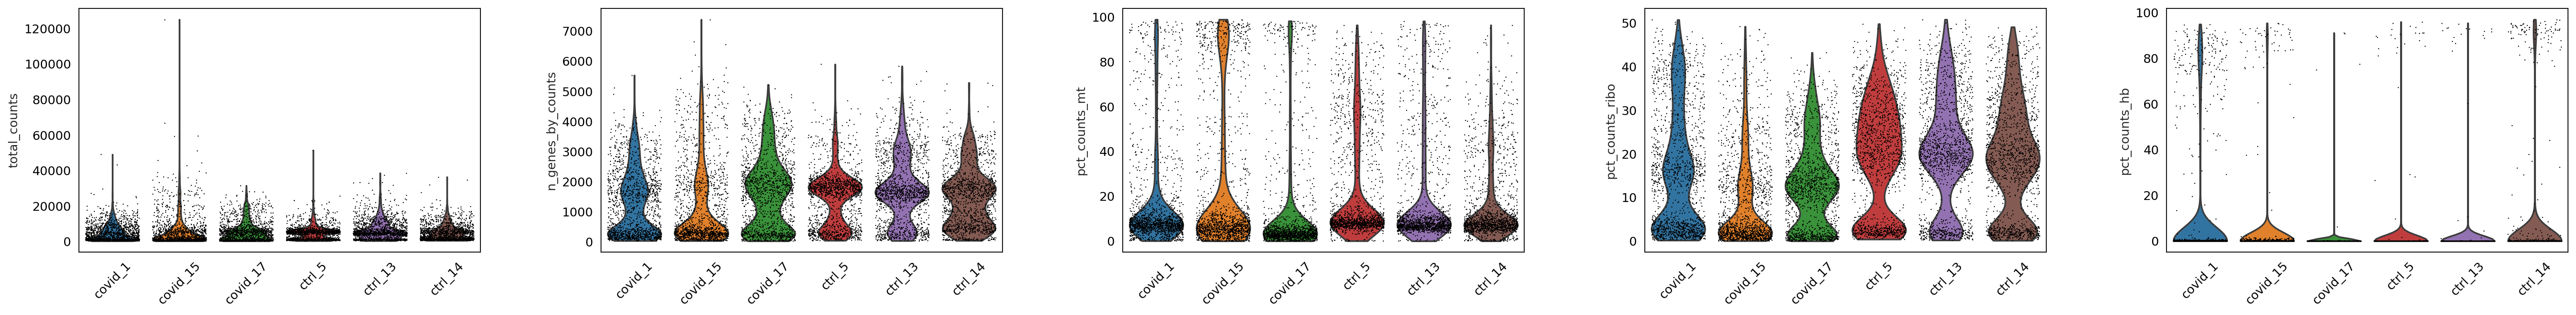

In [ ]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts',  'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

As you can see, there is quite some difference in quality for the 4 datasets, with for instance the covid_15 sample having fewer cells with many detected genes and more mitochondrial content. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. And we can plot the different QC-measures as scatter plots.

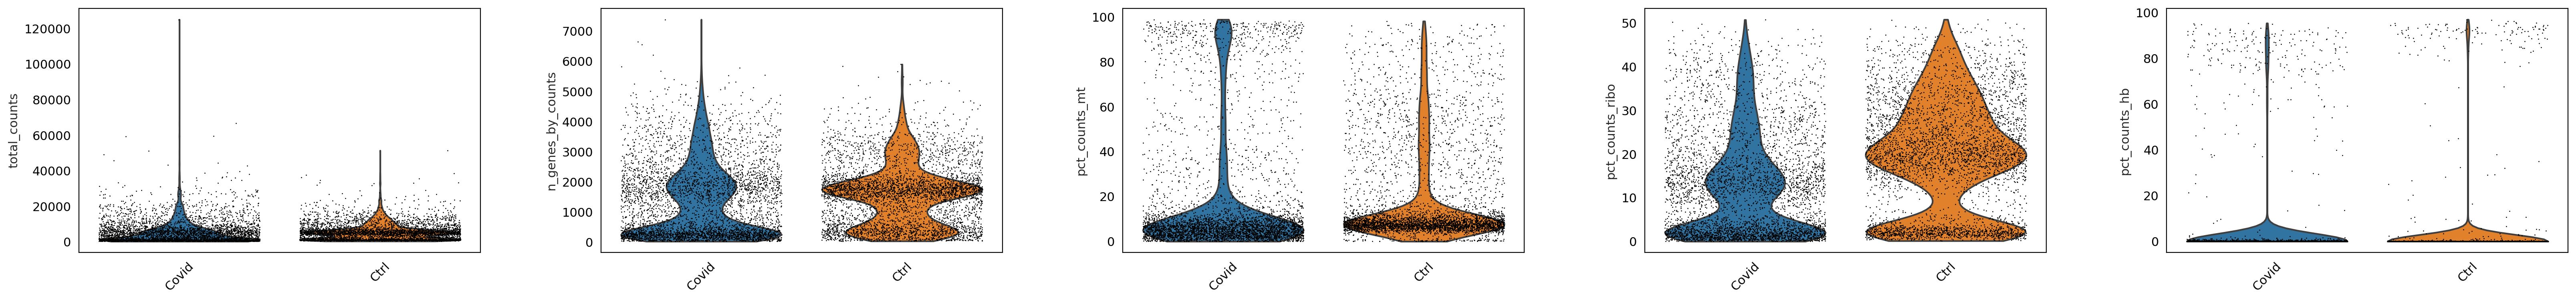

In [ ]:
sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts',  'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'type', rotation= 45)

<Axes: title={'center': 'pct counts mt'}, xlabel='total_counts', ylabel='n_genes_by_counts'>

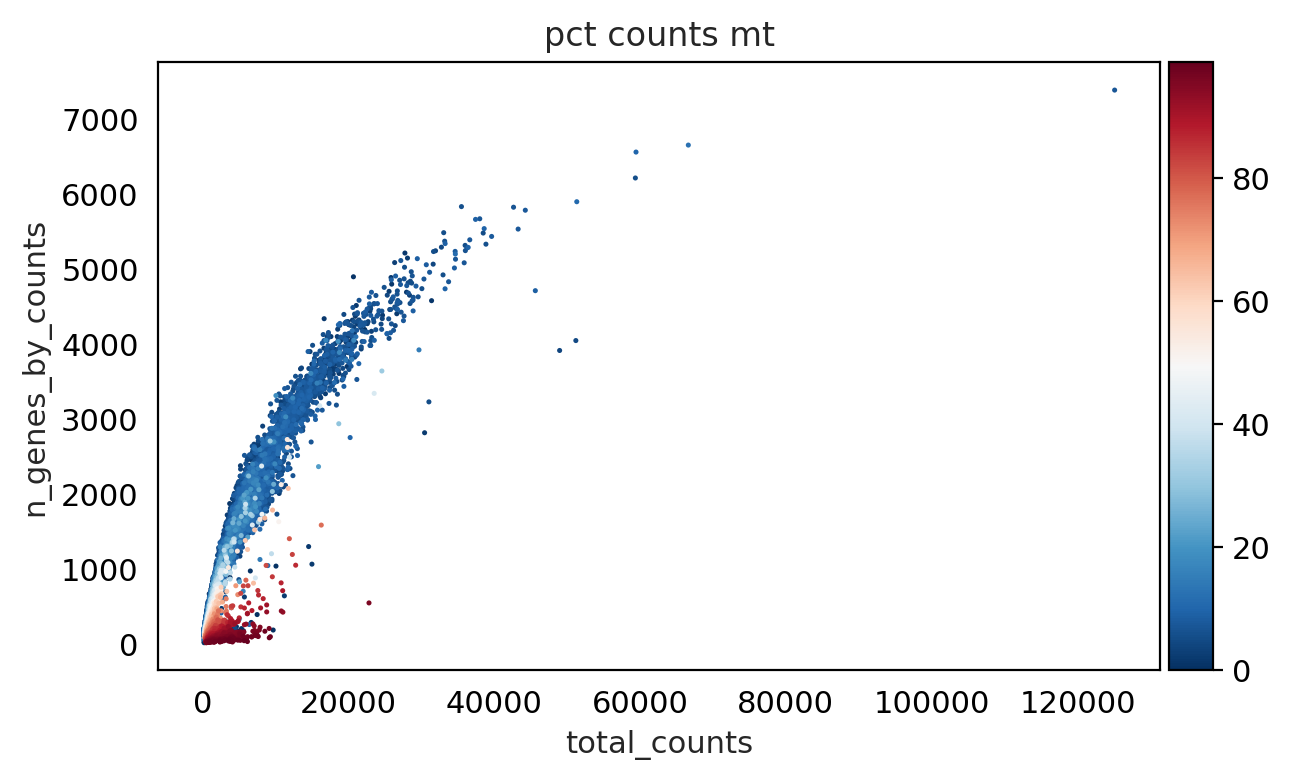

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show= False,   legend_loc= "best")

As we can see from above plot : genes with low counts have more percentage mitochondria and some cells have less mitochondria .

### Filtering (Joint Effect)

We have to filter cells by considering joint effects by these WC metrics we have calculated in previous cells .

We use Automatic method MAD : which depends on Median and Standard deviation 

We first calculate outliers by each od these QC effects

#### Filter Using Automatic Method : MAD

In [ ]:
#@title Create outlier function  

# function that takes a metric, i.e. a column in .obs and the number of MADs (nmad)

# Function take 3 Arguments : 1) Adata object , 2) Metric colum for condition 3) nmads = 3 or 5 or ...?

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [ ]:
adata.obs.head(3)

,type,sample,batch,n_genes_by_counts,total_counts,pct_counts_in_top_20_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
AGGGTCCCATGACCCG-1-0,Covid,covid_1,0,2140,7698.0,24.123149,525.0,6.819953,2564.0,33.307353,2.0,0.025981
TACCCACAGCGGGTTA-1-0,Covid,covid_1,0,3391,13416.0,21.414729,952.0,7.096005,2264.0,16.875373,6.0,0.044723
CCCAACTTCATATGGC-1-0,Covid,covid_1,0,3654,16498.0,22.402715,1253.0,7.594860,2723.0,16.505031,1.0,0.006061


In [ ]:
#@title use QC metrices to find outlier cells 

adata.obs["outlier"] = (
    is_outlier(adata, "total_counts", 5)
    | is_outlier(adata, "n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)


print(adata.obs.outlier.value_counts())

adata.obs.head(3)



False    6898
True     2102
Name: outlier, dtype: int64


,type,sample,batch,n_genes_by_counts,total_counts,pct_counts_in_top_20_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,outlier
AGGGTCCCATGACCCG-1-0,Covid,covid_1,0,2140,7698.0,24.123149,525.0,6.819953,2564.0,33.307353,2.0,0.025981,False
TACCCACAGCGGGTTA-1-0,Covid,covid_1,0,3391,13416.0,21.414729,952.0,7.096005,2264.0,16.875373,6.0,0.044723,False
CCCAACTTCATATGGC-1-0,Covid,covid_1,0,3654,16498.0,22.402715,1253.0,7.594860,2723.0,16.505031,1.0,0.006061,False


In [ ]:
#@title use Mitochondrial QC metric to find outlier cells

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8    #cells with a percentage of mitochondrial counts exceeding 8 % are filtered out
)

print(adata.obs.mt_outlier.value_counts())

adata.obs.head(3)


False    4762
True     4238
Name: mt_outlier, dtype: int64


,type,sample,batch,n_genes_by_counts,total_counts,pct_counts_in_top_20_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,outlier,mt_outlier
AGGGTCCCATGACCCG-1-0,Covid,covid_1,0,2140,7698.0,24.123149,525.0,6.819953,2564.0,33.307353,2.0,0.025981,False,False
TACCCACAGCGGGTTA-1-0,Covid,covid_1,0,3391,13416.0,21.414729,952.0,7.096005,2264.0,16.875373,6.0,0.044723,False,False
CCCAACTTCATATGGC-1-0,Covid,covid_1,0,3654,16498.0,22.402715,1253.0,7.594860,2723.0,16.505031,1.0,0.006061,False,False


In [ ]:
#@title Filter out cells with Above QC metrices :

print(f"Total number of cells  Before Filtering : {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print("")

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells  Before Filtering : 9000

Number of cells after filtering of low quality cells: 4205


### Plot Filtered QC

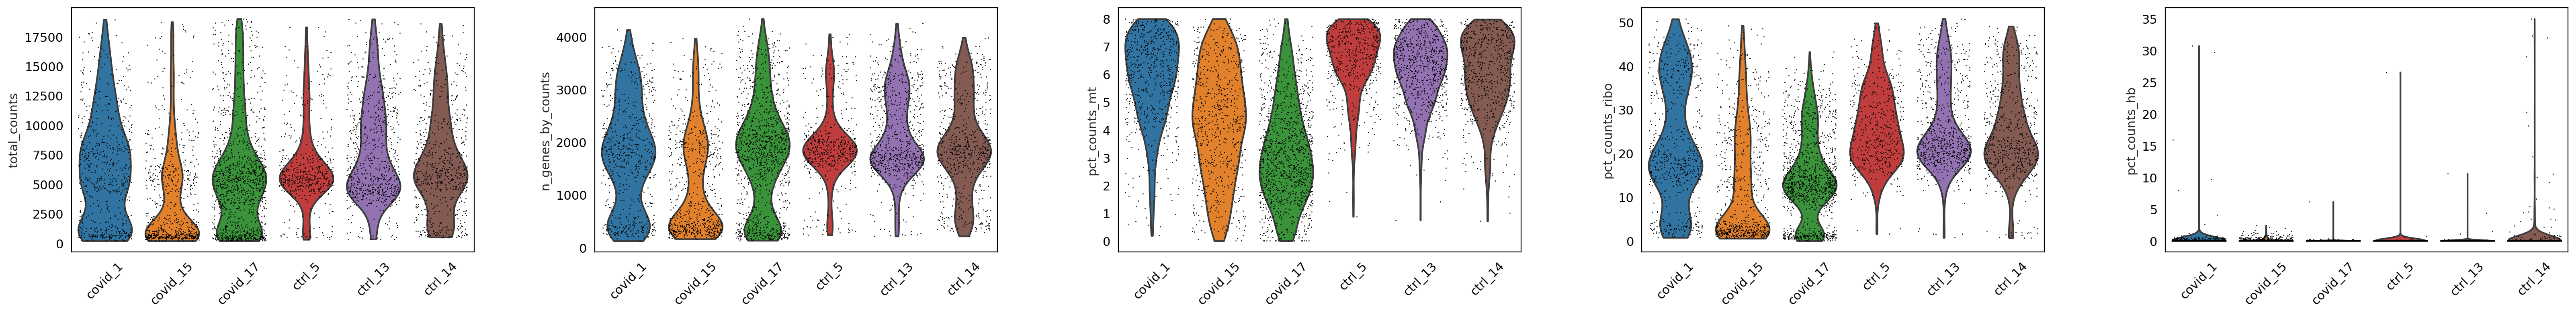

In [ ]:
#@title Filtered Data Plot

sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts',  'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

<Axes: title={'center': 'pct counts mt'}, xlabel='total_counts', ylabel='n_genes_by_counts'>

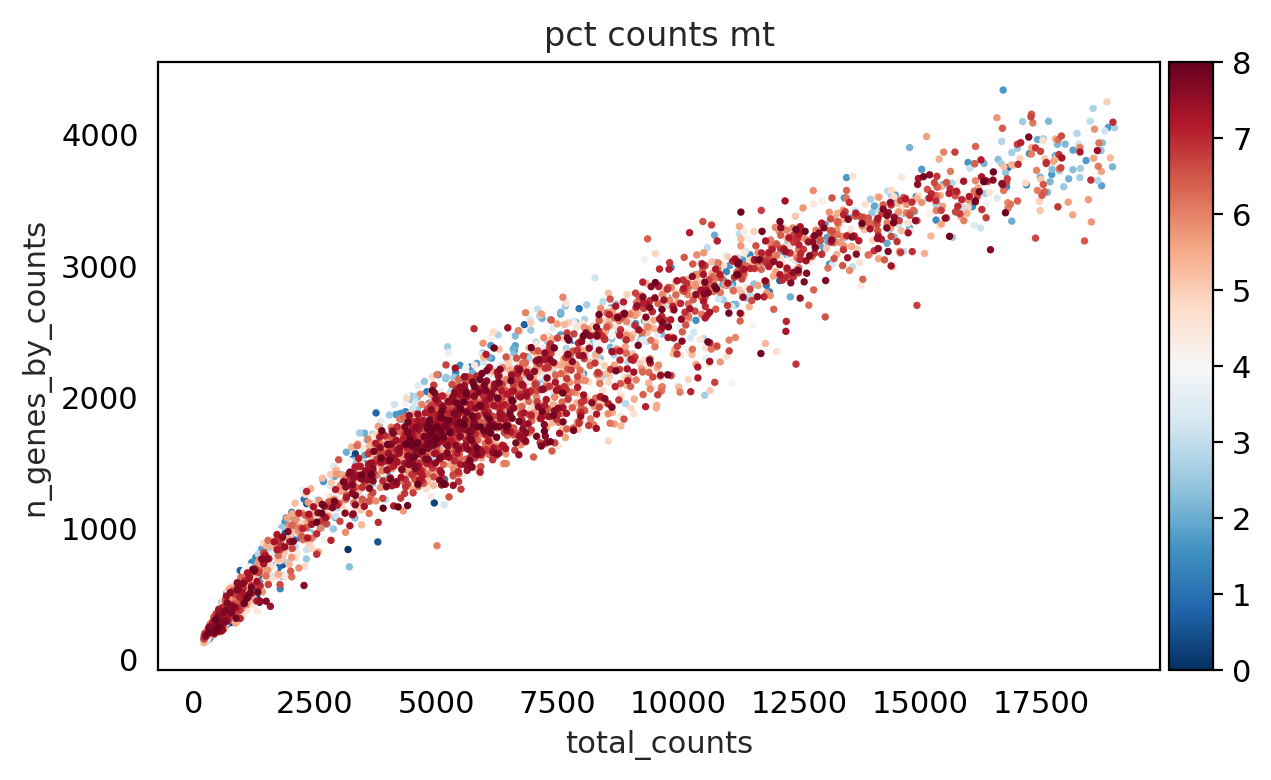

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show= False,   legend_loc= "best")

### ambient RNA correction using scAR :



> To work with scAR we need following : 


*   raw Anndata (unfitered from sequencing machine , which contain Empty droplets and cells with only free mRNA )
*   Filtered data 



> Then we estimate Ambient profile from raw and filtered data


> Then we use Machine learning to train data to identify Ambient RNA and then we correct count matrix with respect to Ambient profile 









setup_anndata is inspired by EmptyDrops  which assumes that cell-free droplets are sampled from a multinomial distribution.

1) It first calculates an initial ambient profile by averaging all droplets in raw_adata

2) It tested whether droplets fit the multinomial distribution (the ambient profile as the prob parameter). The relatively high probabilities suggest cell-free droplets

3) It re-calculates the ambient profile using the identified cell-free droplets

4) It repeats step 2 and step 3 for iterations

5) The final ambient profile is saved in adata.uns

In [ ]:
#@title Read adata_raw

adata_raw = sc.read_h5ad("/content/drive/MyDrive/scRNA_using_Python/Objects/adata_raw_covid.h5ad")

adata_raw

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

2023-05-28 05:45:56|INFO|setup_anndata|Randomly sample 9000 droplets from 9000 droplets.
INFO:setup_anndata:Randomly sample 9000 droplets from 9000 droplets.
2023-05-28 05:45:56|INFO|setup_anndata|Estimating ambient profile for ['Gene Expression']
Categories (1, object): ['Gene Expression']...
INFO:setup_anndata:Estimating ambient profile for ['Gene Expression']
Categories (1, object): ['Gene Expression']...
2023-05-28 05:46:04|INFO|setup_anndata|Iteration: 1
INFO:setup_anndata:Iteration: 1
2023-05-28 05:46:12|INFO|setup_anndata|Iteration: 2
INFO:setup_anndata:Iteration: 2
2023-05-28 05:46:20|INFO|setup_anndata|Iteration: 3
INFO:setup_anndata:Iteration: 3
2023-05-28 05:46:20|INFO|setup_anndata|Estimated ambient profile for Gene Expression saved in adata.uns
INFO:setup_anndata:Estimated ambient profile for Gene Expression saved in adata.uns
2023-05-28 05:46:20|INFO|setup_anndata|Estimated ambient profile for all features saved in adata.uns
INFO:setup_anndata:Estimated ambient profile fo

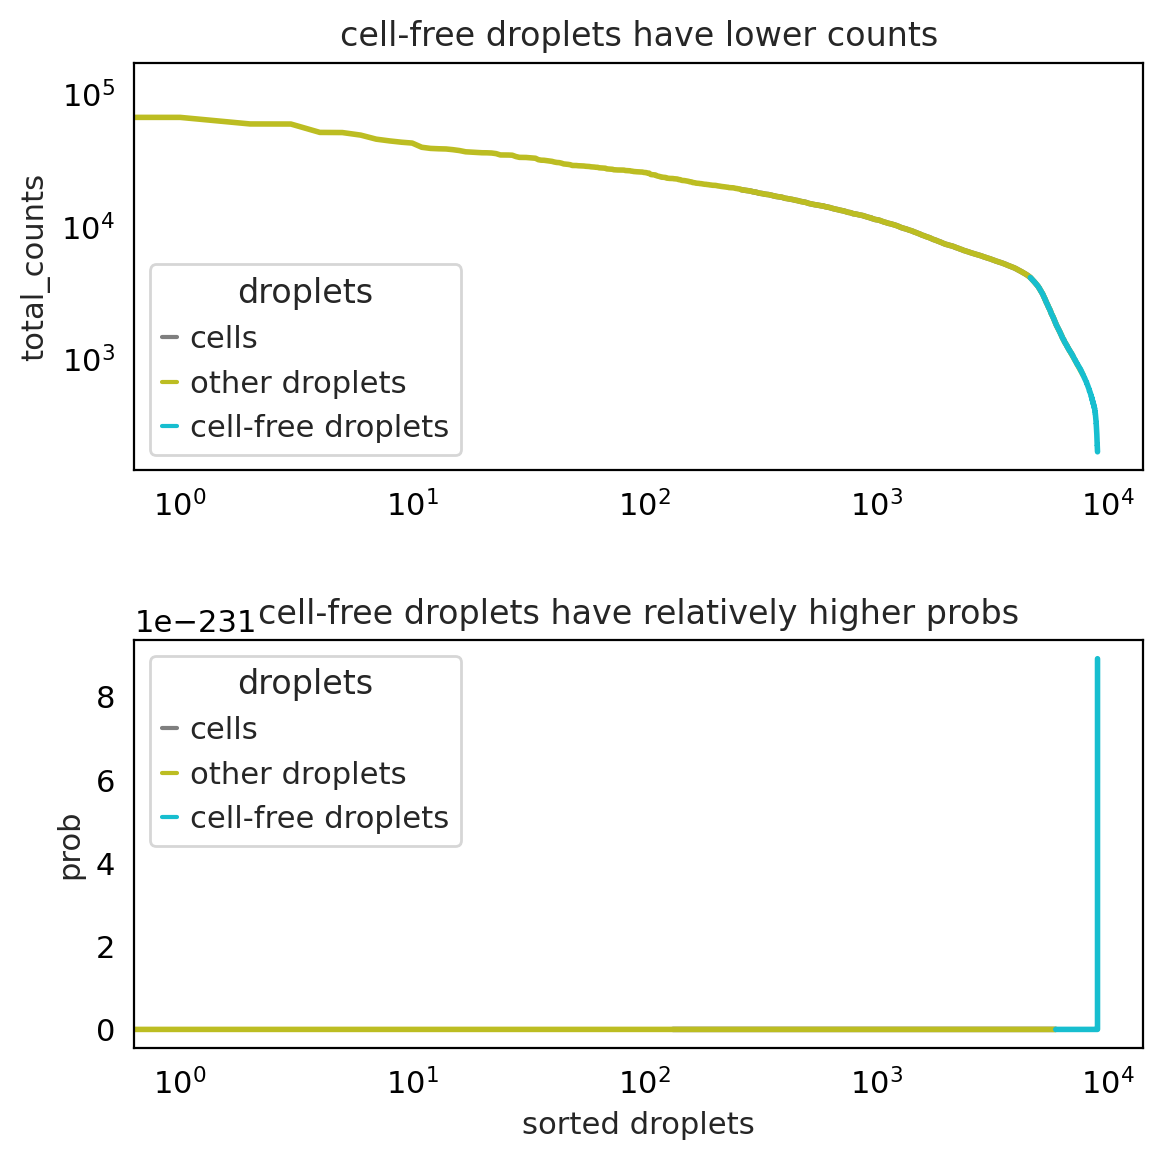

In [ ]:
#@title Estimate the ambient profile



setup_anndata(
    adata = adata,
    raw_adata = adata_raw,
    prob = 0.895,
    kneeplot = True
)

In [ ]:
#@title Traine Ambient Data 

adata_scar = model(raw_count=adata, # In the case of Anndata object, scar will automatically use the estimated ambient_profile present in adata.uns.
                      ambient_profile=adata.uns['ambient_profile_Gene Expression'],
                      feature_type='mRNA',
                      sparsity=1,
                      device='cuda' # Both cpu and cuda are supported.
                     )

adata_scar.train(epochs=200,
                    batch_size=64,
                    verbose=True
                   )

# After training, we can infer the native true signal
adata_scar.inference(batch_size=256)  # by defaut, batch_size = None, set a batch_size if getting a memory issue

2023-05-28 05:46:42|INFO|model|cuda will be used.
INFO:model:cuda will be used.
2023-05-28 05:46:46|INFO|VAE|Running VAE using the following param set:
INFO:VAE:Running VAE using the following param set:
2023-05-28 05:46:46|INFO|VAE|...denoised count type: mRNA
INFO:VAE:...denoised count type: mRNA
2023-05-28 05:46:46|INFO|VAE|...count model: binomial
INFO:VAE:...count model: binomial
2023-05-28 05:46:46|INFO|VAE|...num_input_feature: 33538
INFO:VAE:...num_input_feature: 33538
2023-05-28 05:46:46|INFO|VAE|...NN_layer1: 150
INFO:VAE:...NN_layer1: 150
2023-05-28 05:46:46|INFO|VAE|...NN_layer2: 100
INFO:VAE:...NN_layer2: 100
2023-05-28 05:46:46|INFO|VAE|...latent_space: 15
INFO:VAE:...latent_space: 15
2023-05-28 05:46:46|INFO|VAE|...dropout_prob: 0.00
INFO:VAE:...dropout_prob: 0.00
2023-05-28 05:46:46|INFO|VAE|...expected data sparsity: 1.00
INFO:VAE:...expected data sparsity: 1.00
2023-05-28 05:46:46|INFO|model|kld_weight: 1.00e-05
INFO:model:kld_weight: 1.00e-05
2023-05-28 05:46:46|INFO

Training: 100%|██████████| 200/200 [03:38<00:00,  1.09s/it, Loss=5.4521e+03]


In [ ]:
#@title Denoised counts :
denoised_count = pd.DataFrame(adata_scar.native_counts, index=adata.obs_names, columns=adata.var_names)

print("")
print(denoised_count.shape)
print("=================================================")
denoised_count.head()


(4205, 33538)


,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
AGGGTCCCATGACCCG-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TACCCACAGCGGGTTA-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCCAACTTCATATGGC-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTCCTAGTGACTGTT-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CCTAAGACAGATTAAG-1-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title Add Denoised count (Ambient RNA corrected ) to adata :

adata

adata.layers["counts"] = adata.X
adata.layers["ambient_counts"] = adata_scar.native_counts
adata.X = adata.layers["ambient_counts"]


adata

AnnData object with n_obs × n_vars = 4205 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'type_colors', 'ambient_profile_Gene Expression', 'ambient_profile_all'
    layers: 'counts', 'ambient_counts'

In [ ]:
adata.var.head()

,gene_ids,feature_types,genome,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False,25,0.002778,99.722222,25.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False,1,0.000111,99.988889,1.0


### Filter Genes 

In [ ]:
#@title Filter genes :
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")



Total number of genes: 33538
Number of genes after cell filter: 7662


In [ ]:
# As we have . we can remove genes correspond to Mirochondria , Ribosomal and MALAT1
# Because High level of MALAT1 and MT referes to Technical variation

 # group genes with MALAT1 , MT and HB and remove 
malat1 = adata.var_names.str.startswith('MALAT1')
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

print("before removal of genes :" , adata.n_obs, adata.n_vars)

adata = adata[:,keep]

print("After removal of genes :" ,adata.n_obs, adata.n_vars)



before removal of genes : 4205 7662
After removal of genes : 4205 7650


In [ ]:
#@title install pybiomart



### Cell Cycle Scoring

In [ ]:
#@title Cell Cycle scoring : 


!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi


In [ ]:

cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
33


In [ ]:

# save normalized counts in raw slot.
adata.cycle = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata.cycle, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata.cycle)

# scale
sc.pp.scale(adata.cycle)


In [ ]:
sc.tl.score_genes_cell_cycle(adata.cycle, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
adata.cycle.obs.phase.value_counts()

G1     1474
G2M    1371
S      1360
Name: phase, dtype: int64

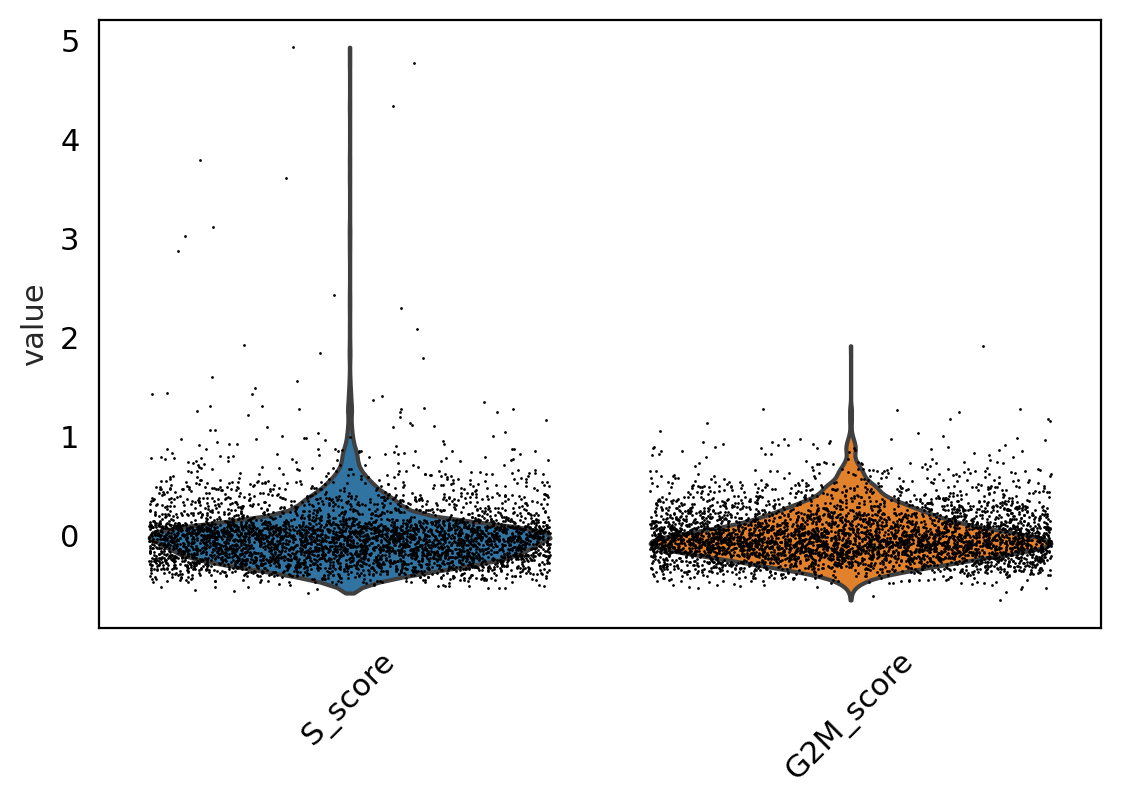

In [ ]:
sc.pl.violin(adata.cycle, ['S_score', 'G2M_score'],
             jitter=0.4,  rotation=45)

### Doublet detection 

In [ ]:
#@title Doublet Detection :

print(adata.shape)



(4205, 7650)


In [ ]:
# Change the layer of count  to Ambient counts 

adata.X = adata.layers["ambient_counts"]

In [ ]:
#@title Run scvi setup model

scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:27<00:00,  2.70it/s, loss=3.52e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:27<00:00,  2.71it/s, loss=3.52e+03, v_num=1]


In [ ]:
#@title Train solo model 

solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:03<00:00,  3.24it/s, loss=0.339, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:03<00:00,  3.23it/s, loss=0.339, v_num=1]


In [ ]:
#@title Predict the Doublet

df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
AGGGTCCCATGACCCG-1-0,-1.240547,1.317724,singlet
TACCCACAGCGGGTTA-1-0,0.230032,-0.015135,doublet
CCCAACTTCATATGGC-1-0,0.087104,0.086796,doublet
ATTCCTAGTGACTGTT-1-0,-1.723657,1.353531,singlet
CCTAAGACAGATTAAG-1-0,-1.451537,1.859437,singlet
...,...,...,...
GCTGCAGTCTGTCAGA-14-5,-1.007731,0.915832,singlet
GAGGCCTTCTCCTGCA-14-5,-0.019297,0.247610,singlet
CCCTAACAGTTTCTTC-14-5,-0.336324,-0.266451,singlet
GGGATGATCAAGCTTG-14-5,0.087399,-0.348760,doublet


In [ ]:
#@title Number of Doublets:

len(df[df.prediction == 'doublet'])  # pretty high number


669

In [ ]:

#THIS STEP IS NOT NECESSARY, just to visuallize results
adata_doublet = adata

adata_doublet




AnnData object with n_obs × n_vars = 4205 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'sample_colors', 'type_colors', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'log1p', '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts', 'ambient_counts'

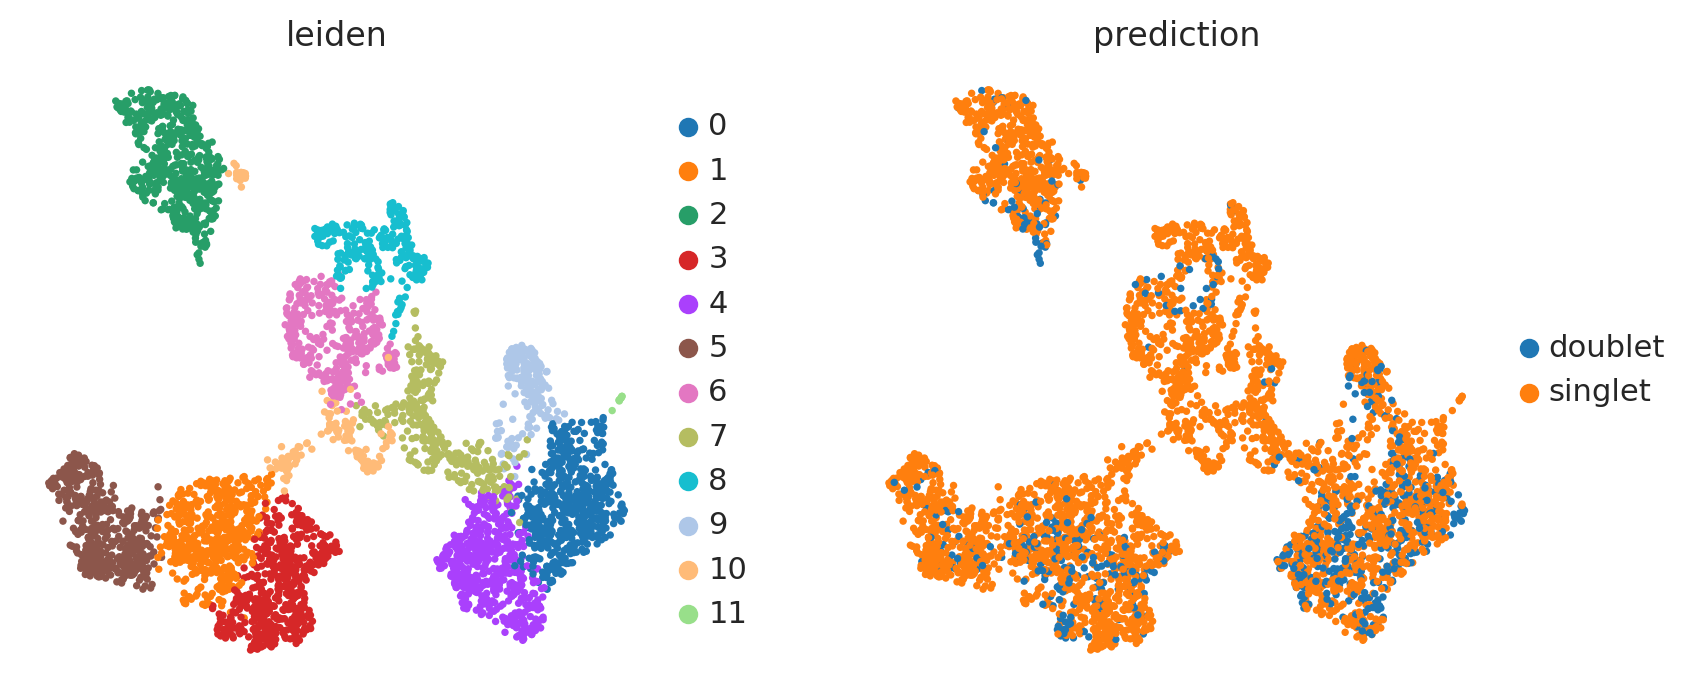

In [ ]:
adata_doublet.obs['prediction'] = df.prediction
sc.pp.normalize_total(adata_doublet, target_sum = 1e4)
sc.pp.log1p(adata_doublet)
sc.tl.pca(adata_doublet)
sc.pp.neighbors(adata_doublet)
sc.tl.umap(adata_doublet)
sc.tl.leiden(adata_doublet, resolution = 0.5)

with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_doublet, color = ['leiden', 'prediction'])

In [ ]:

doublet_d = dict(zip(df.index, df.prediction))

def doublet_function(x):
    try:
        return doublet_d[x]
    except:
        return 'filtered'


In [ ]:


adata.obs['doublet'] = adata.obs.index.map(doublet_function)

In [ ]:
adata

AnnData object with n_obs × n_vars = 4205 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'sample_colors', 'type_colors', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'prediction_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'ambient_counts'
    obsp: 'distances', 'connectivities'

In [ ]:
#@title remove predicted doublets

adata = adata[adata.obs.doublet == 'singlet']

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'sample_colors', 'type_colors', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'prediction_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'ambient_counts'
    obsp: 'distances', 'connectivities'

### Save QC Filtered Data

In [ ]:
save_file = 'Objects/sc_qc_filtered_covid.h5ad'
adata.write_h5ad(save_file)